<a href="https://colab.research.google.com/github/GPhMorin/geneo/blob/main/examples/correlation_clustermap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation computation and clustering

This script computes pairwise relationship correlations of the probands from the **genea140** dataset and plots a `clustermap` of those correlations using Seaborn, inspired by figure 2 of [the following article](https://doi.org/10.1126/science.abi8264):
> Wohns, A. W., Wong, Y., Jeffery, B., Akbari, A., Mallick, S., Pinhasi, R., ... & McVean, G. (2022). A unified genealogy of modern and ancient genomes. *Science, 375*(6583), eabi8264.

In [1]:
!python --version

Python 3.10.12


The GENEO toolkit will be used for loading the datasets, identifying the probands, and computing the kinship coefficients.

In [2]:
%pip install https://github.com/GPhMorin/geneo/archive/main.zip

     | 1.1 MB 7.1 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for geneo: filename=geneo-0.1.0-cp310-cp310-linux_x86_64.whl size=476103 sha256=633f679044071854fbe49e91a6c5ed74e7de9e3ccccbea466359d4aa47923841
  Stored in directory: /tmp/pip-ephem-wheel-cache-zttyqf6v/wheels/89/82/c1/060b4460912dd0579653a87158a8c256172b90f4689b85460d
Successfully built geneo


The GENEO toolkit makes extensive use of Pandas dataframes, in this case, for the pairwise kinship coefficients and for the **pop140** dataset. Seaborn will be used for plotting.

In [3]:
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.patches import Patch
import seaborn as sns
import colorcet as cc
import geneo as gen

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [4]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [5]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
...,...,...
135,443161,Quebec
136,443159,Quebec
137,443165,Quebec
138,443167,Quebec


Now let's compute the pairwise kinship coefficients. On a recent computer, it should take just a few seconds to run the next line, especially if you have OpenMP detected during the toolkit's installation.

In [6]:
phi = gen.phi(genea140)

The pairwise kinship coefficients are then transformed into correlations, where an individual with themself has a correlation of 1 and two unrelated individuals have a correlation of 0.

In [7]:
corr = phi.copy()
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i != j:
            corr.iloc[i, j] = corr.iloc[i, j] / (np.sqrt(phi.iloc[i, i]) * np.sqrt(phi.iloc[j, j]))
for i in range(corr.shape[0]):
    corr.iloc[i, i] = 1
corr

,217891,218089,219947,288708,288764,302710,302711,302716,302717,302718,...,454422,676521,677273,717537,717634,717709,718567,802424,868387,868572
217891,1.000000,0.000470,0.011566,0.010293,0.016159,0.009611,0.009277,0.013705,0.017757,0.011252,...,0.006462,0.002459,0.000713,0.014775,0.005760,0.018028,0.009377,0.002703,0.006734,0.019413
218089,0.000470,1.000000,0.000540,0.000459,0.000457,0.000659,0.000599,0.000442,0.000524,0.000413,...,0.001091,0.001365,0.000675,0.000675,0.000285,0.000530,0.000599,0.001260,0.000518,0.000628
219947,0.011566,0.000540,1.000000,0.012654,0.014624,0.009940,0.010207,0.015837,0.015724,0.012170,...,0.007027,0.002384,0.000783,0.013203,0.005771,0.017724,0.009110,0.002888,0.008379,0.013187
288708,0.010293,0.000459,0.012654,1.000000,0.016052,0.010532,0.010758,0.015169,0.017136,0.012820,...,0.006450,0.002042,0.000646,0.015056,0.006778,0.018478,0.010838,0.002329,0.009404,0.013634
288764,0.016159,0.000457,0.014624,0.016052,1.000000,0.012847,0.014080,0.019956,0.024260,0.016396,...,0.009234,0.002809,0.000618,0.019971,0.009316,0.024623,0.012552,0.002712,0.011390,0.017725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717709,0.018028,0.000530,0.017724,0.018478,0.024623,0.018653,0.017046,0.024657,0.029740,0.020476,...,0.009979,0.002743,0.000719,0.026262,0.010393,1.000000,0.016985,0.003401,0.012319,0.024216
718567,0.009377,0.000599,0.009110,0.010838,0.012552,0.009096,0.010488,0.012314,0.015161,0.013128,...,0.006177,0.002354,0.000810,0.013218,0.005727,0.016985,1.000000,0.002467,0.007895,0.011369
802424,0.002703,0.001260,0.002888,0.002329,0.002712,0.002907,0.002635,0.002644,0.003266,0.002475,...,0.002972,0.002252,0.001239,0.003183,0.001791,0.003401,0.002467,1.000000,0.002239,0.003344
868387,0.006734,0.000518,0.008379,0.009404,0.011390,0.007728,0.008718,0.010051,0.010041,0.016386,...,0.004919,0.002113,0.000711,0.009632,0.004469,0.012319,0.007895,0.002239,1.000000,0.009522


The minimum non-null value will be used for plotting the color bar.

In [8]:
min_phi = phi[phi != 0].min().min()
min_phi

2.384185791015625e-07

In another situation where the genealogies are bigger, you can run `gen.phi(genea140, compute=False)` to get information about the minimum RAM required.

In [9]:
gen.phi(genea140, compute=False)

You will require at least 2.84 GB of RAM.


Let's create a dictionary to easily get the corresponding population of an individual.

In [10]:
ind_to_pop = {ind: pop for index, (ind, pop) in pop140.iterrows()}
ind_to_pop

{409682: 'Saguenay',
 409687: 'Saguenay',
 868387: 'Saguenay',
 717537: 'Saguenay',
 302711: 'Saguenay',
 302716: 'Saguenay',
 868572: 'Saguenay',
 717634: 'Saguenay',
 409808: 'Saguenay',
 718567: 'Saguenay',
 677273: 'Saguenay',
 717709: 'Saguenay',
 302717: 'Saguenay',
 219947: 'Saguenay',
 288708: 'Saguenay',
 454422: 'Saguenay',
 302718: 'Saguenay',
 218089: 'Saguenay',
 302710: 'Saguenay',
 217891: 'Saguenay',
 288764: 'Saguenay',
 453612: 'Saguenay',
 408319: 'Gaspesia-Acadian',
 408480: 'Gaspesia-Acadian',
 408920: 'Gaspesia-Acadian',
 408926: 'Gaspesia-Acadian',
 408475: 'Gaspesia-Loyalist',
 408477: 'Gaspesia-Loyalist',
 408790: 'Gaspesia-Loyalist',
 409098: 'Gaspesia-Loyalist',
 409100: 'Gaspesia-Loyalist',
 409032: 'Gaspesia-Loyalist',
 408992: 'Gaspesia-Loyalist',
 409031: 'Gaspesia-Loyalist',
 409215: 'Gaspesia-Loyalist',
 409266: 'Gaspesia-Loyalist',
 409437: 'Gaspesia-Loyalist',
 409434: 'Gaspesia-Loyalist',
 409422: 'Gaspesia-Loyalist',
 409349: 'Gaspesia-Loyalist',
 4

Here's a dictionary to convert a population to its corresponding abbreviation.

In [11]:
population_to_pop = {
    'Gaspesia-Acadian': 'ACA',
    'Gaspesia-FrenchCanadian': 'GFC',
    'Gaspesia-Loyalist': 'LOY',
    'Montreal': 'MON',
    'NorthShore': 'NS',
    'Quebec': 'QUE',
    'Saguenay': 'SAG'
}

Now, a dictionary to get the color of a corresponding abbreviation.

In [12]:
pop_to_color = {
    'ACA': 'red',
    'GFC': 'purple',
    'LOY': 'lime',
    'MON': 'orange',
    'NS': 'cyan',
    'QUE': 'blue',
    'SAG': 'darkgreen',
}

Let's extract the color of each proband.

In [13]:
pro = gen.pro(genea140)
pops = [ind_to_pop[ind] for ind in pro]
colors = [pop_to_color[population_to_pop[pop]] for pop in pops]
colors

['darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'purple',
 'red',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'purple',
 'lime',
 'lime',
 'red',
 'purple',
 'red',
 'red',
 'lime',
 'lime',
 'red',
 'red',
 'red',
 'purple',
 'red',
 'purple',
 'red',
 'purple',
 'purple',
 'lime',
 'lime',
 'lime',
 'red',
 'purple',
 'purple',
 'red',
 'red',
 'red',
 'red',
 'purple',
 'red',
 'lime',
 'lime',
 'red',
 'red',
 'red',
 'red',
 'lime',
 'red',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'lime',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'orange',
 'orange',
 'orange',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'orange',
 'orange',
 'orange',
 'orange',
 'orange',
 'orange',

In [22]:
similarity = 1/-np.log2(corr)
similarity[similarity == -np.inf] = 0
similarity.iloc[:5, :5]

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


,217891,218089,219947,288708,288764
217891,0.000000,0.090454,0.155424,0.151464,0.168026
218089,0.090454,0.000000,0.092121,0.090166,0.090134
219947,0.155424,0.092121,0.000000,0.158624,0.164056
288708,0.151464,0.090166,0.158624,0.000000,0.167753
288764,0.168026,0.090134,0.164056,0.167753,0.000000


The following mask will remove the values of the lower triangle, including the diagonal.

In [23]:
n = phi.shape[0]
mask = np.zeros((n, n), dtype=bool)
Z = hierarchy.linkage(1 - similarity, metric='euclidean', method='average', optimal_ordering=True)
ordering = hierarchy.leaves_list(Z)
for i in range(n):
    for j in range(n):
        if i >= j:
            mask[ordering[i], ordering[j]] = True
mask

array([[ True,  True, False, ...,  True, False, False],
       [False,  True, False, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [ True,  True, False, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True,  True]])

Finally, let's see the results.

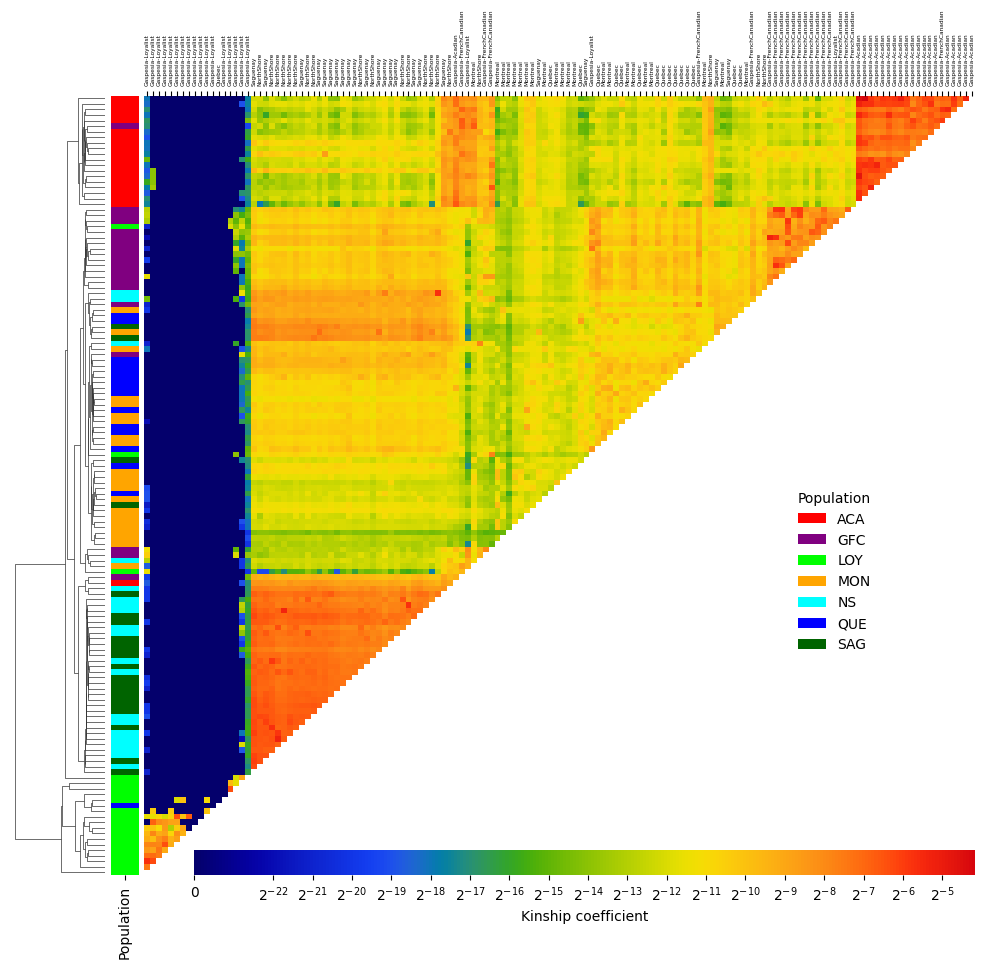

In [24]:
cm = sns.clustermap(phi,
                    mask=mask,
                    cmap='cet_rainbow4',
                    row_colors=colors,
                    xticklabels=pops,
                    yticklabels=False,
                    cbar_kws={'label': 'Kinship coefficient',
                              'orientation': 'horizontal'},
                    dendrogram_ratio=(.1, 0),
                    figsize=(10, 10),
                    norm=SymLogNorm(linthresh=min_phi, base=2),
                    row_linkage=Z,
                    col_linkage=Z)

# Invert the x-axis
cm.ax_heatmap.invert_xaxis()

# Colorbar
cm.ax_cbar.yaxis.set_ticks_position('left')
cm.ax_cbar.yaxis.set_label_position('left')
x0, y0, w0, h0 = cm.cbar_pos
x1, y1, w1, h1 = cm.ax_heatmap.get_position().bounds
cm.ax_cbar.set_position([x1 + w0, y1, w1 - w0, w0 / 2])

# Add a label to the row colors
cm.ax_row_colors.set_xticks([0.5])
cm.ax_row_colors.set_xticklabels(['Population'], rotation=90)

# Move the xticklabels to the top
cm.ax_heatmap.xaxis.set_ticks_position('top')
cm.ax_heatmap.xaxis.set_label_position('top')
cm.ax_heatmap.xaxis.set_tick_params(rotation=90, labelsize=720*w1/phi.shape[0])

# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop) for pop, color in pop_to_color.items()]

# Add the legend to the plot
cm.ax_heatmap.legend(handles=legend_elements,
                     title='Population',
                     bbox_to_anchor=(w1, h1 / 2),
                     loc='center',
                     frameon=False)
plt.show()